# Module 6: Partial Differential Equations

### PROBLEM 1 (50 pts.; 50/50 for code & discussion) 
**The Schrodinger equation and the Crank-Nicolson method**

_Refer to Exercise 9.8 in the Newman text._ In this problem, you will use the Crank-Nicolson method to solve the full time-dependent Schrodinger equation and hence develop a picture of how a wavefunction evolves over time.

Consider an electron (mass $M = 9.109 \times 10^{-31}$ kg) in a box of length $L = 10^{-8}$ m. Suppose that at time $t = 0$ the wavefunction of the electron has the form

$$ \psi(x,0) = \exp\left[-\frac{(x-x_0)^2}{2\sigma^2}\right]e^{i\kappa x},$$
where $x_0 = \frac{L}{2}$, $\sigma = 1 \times 10^{-10}$ m, $\kappa = 5 \times 10^{10} {\rm m}^{-1}$,  and $\psi = 0$ on the walls at $x = 0$ and $x = L$.

1. Perform a single step of the Crank-Nicolson method for this electron, calculating the vector $\psi(t)$ of values of the wavefunction, given the initial wavefunction above and using $N = 1000$ spatial slices with $a = L/N$. Your program will have to perform the following steps. First, given the vector $\psi(0)$ at $t = 0$, you will have to multiply by the matrix $\bf{B}$ to get a vector $\bf{v} = \bf{B}\psi$. Because of the tridiagonal form of $\bf{B}$, this is fairly simple. The $i$th component of $\bf{v}$ is given by
$$ v_i = b_1\psi_i + b_2(\psi_{i+1} + \psi_{i-1}).$$

   You will also have to choose a value for the time-step $h$. A reasonable choice is $h = 10^{-18}$ s. *(15 pts.)*

2. Second you will have to solve the linear system ${\bf Ax}= {\bf v}$ for $\bf{x}$, which gives you the new value of $\psi$. You could do this using a standard linear equation solver like the function $\tt solve$ in numpy's $\tt linalg$. *(10 pts.)*

3. Once you have the code in place to perform a single step of the calculation, extend your program to perform repeated steps and hence solve for $\psi$ at a sequence of times a separation $h$ apart. Note that the matrix $\bf A$ is independent of time, so it doesn't change from one step to another. You can set up the matrix just once and then keep on reusing it for every step. *(15 pts.)*

4. Make an animation of the solution by displaying the real part of the wavefunction at each time-step. You can use the function rate from the package visual to ensure a smooth frame-rate for your animation-- see Section 3.5 on page 117 of the Newman text. 

   Run your animation for a while and describe what you see. Write a few sentences explaining in physics terms what is going on in the system. *(10 pts.)*

1. First, we define the function ```banded``` from Newman's resources [(link)](http://www-personal.umich.edu/~mejn/cp/programs/banded.py). We will use this in Part 2 to solve for the banded system of linear equations.

In [ ]:
######################################################################
#
# Function to solve a banded system of linear equations using
# Gaussian elimination and backsubstitution
#
# x = banded(A,v,up,down)
#
# This function returns the vector solution x of the equation A.x = v,
# where v is an array representing a vector of N elements, either real
# or complex, and A is an N by N banded matrix with "up" nonzero
# elements above the diagonal and "down" nonzero elements below the
# diagonal.  The matrix is specified as a two-dimensional array of
# (1+up+down) by N elements with the diagonals of the original matrix
# along its rows, thus:
#
#   (  -   -  A02 A13 A24 ...
#   (  -  A01 A12 A23 A34 ...
#   ( A00 A11 A22 A33 A44 ...
#   ( A10 A21 A32 A43 A54 ...
#   ( A20 A31 A42 A53 A64 ...
#
# Elements represented by dashes are ignored -- it doesn't matter what
# these elements contain.  The size of the system is taken from the
# size of the vector v.  If the matrix A is larger than NxN then the
# extras are ignored.  If it is smaller, the program will produce an
# error.
#
# The function is compatible with version 2 and version 3 of Python.
#
# Written by Mark Newman <mejn@umich.edu>, September 4, 2011
# You may use, share, or modify this file freely
#
######################################################################

from numpy import copy

def banded(Aa,va,up,down):

    # Copy the inputs and determine the size of the system
    A = copy(Aa)
    v = copy(va)
    N = len(v)

    # Gaussian elimination
    for m in range(N):

        # Normalization factor
        div = A[up,m]

        # Update the vector first
        v[m] /= div
        for k in range(1,down+1):
            if m+k<N:
                v[m+k] -= A[up+k,m]*v[m]

        # Now normalize the pivot row of A and subtract from lower ones
        for i in range(up):
            j = m + up - i
            if j<N:
                A[i,j] /= div
                for k in range(1,down+1):
                    A[i+k,j] -= A[up+k,m]*A[i,j]

    # Backsubstitution
    for m in range(N-2,-1,-1):
        for i in range(up):
            j = m + up - i
            if j<N:
                v[m] -= A[i,j]*v[j]

    return v

We define constants and parameters as given in the problem, matrix entries for $\bf{A}$ and $\bf{B}$ in ```a1, a2, b1, b2``` and a user-defined function ```psi0``` to return the initial wavefunction $\psi(x, t=0)$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp

# define constants
m =  9.109e-31
L =  10**(-8)
x0 = L/2
sigma =  1e-10
kappa =  5e10
hbar = 1.0546e-34 

# define parameters
N =  1000
a =  L/N
h =  10**(-18)

# define matrix entries 
a1 = 1 + 1j*h*hbar/2/m/a**2
a2 = -h*hbar*1j/4/m/a**2
b1 =  1 - 1j* h*hbar/2/m/a**2
b2 =  h*hbar*1j/4/m/a**2

# define initial wavefunction 
def psi0(x):
  return exp(-(x - x0) ** 2 / (2 * sigma ** 2)) * exp(1j * kappa * x)

We initialize 1-D arrays for $x$ and $v$ (```xgrid``` and ```vgrid```), both of length $N+1$. We also define $psi$ (```psi```) with initial values evaluated using the function ```psi0``` (defined above). 

We also define the matrix ```A_banded``` as a 3 by $N+1$ matrix that defines the tridiagonal matrix $A$ following the convention of the ```banded``` function above. In this case, ```up=1``` and ```down=1```.

In [ ]:
# initialize arrays
xgrid = np.linspace(0, L, N+1)
vgrid = np.zeros(N+1, complex)

#initialize wavefunction
psi0 = np.array(list(map(psi0, xgrid)), complex) 
psi = psi0

# define A_banded
A_banded = np.zeros([3, N+1], complex)
A_banded[0,:] = a2
A_banded[1,:] = a1
A_banded[2,:] = a2

Evolving the wavefunction through time would mean that we have to update ```vgrid``` for each timestep. Doing so will give us the wavefunction solution at some time $t'$ from an initial state $\psi_0$. If we perform the operation for several timesteps, we obtain the wavefunction $\psi(t')=\psi'$. You can think of each iteration to be a successive operation of a time evolution operator.

To perform a single step, we first calculate the components of $\bf{v} = \bf{B}\psi$, given by $v_i = b_1\psi_i + b_2(\psi_{i+1}+\psi_{i-1})$. Then, we solve the linear system $\bf{A}\psi(t+h) = \bf{v}$ using the ```banded``` function defined earlier (the last two arguments are ```up=1``` and ```down=1```). This gives the new value of $\psi$. 

In [ ]:
vgrid[1: N] = b1*psi[1:N] + b2*(psi[2:N+1] + psi[0:N-1])
psi = banded(A_banded,vgrid,1,1)

(0.0, 1e-08)

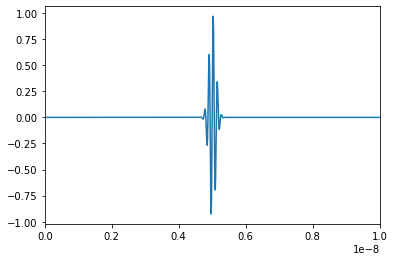

In [ ]:
# plot wavefunction after a single step
plt.plot(xgrid, np.real(psi))
plt.xlim(0,L)

Next, we perform the next 500 steps. We find that the width of the wavefunction is now considerably wider. This means that an electron that was initially localized in a small region, then could probably be in a larger region after some timesteps. This observation follows from the theory. It is expected that particle wave packets would spread rapidly over time.

In [ ]:
for i in range(500):
  vgrid[1: N] = b1*psi[1:N] + b2*(psi[2:N+1] + psi[0:N-1])
  psi = banded(A_banded,vgrid,1,1)

(0.0, 1e-08)

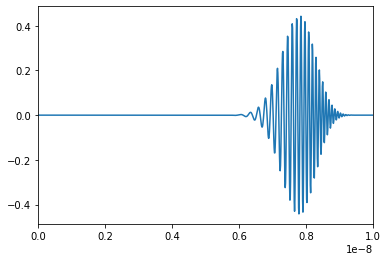

In [ ]:
# plot wavefunction after 500 steps
plt.plot(xgrid, np.real(psi))
plt.xlim(0,L)

After 700 timesteps, we can observe a snapshot for when the leading piece of the wavefunction encounters the perfectly reflecting boundary. This leading piece would then be reflected opposite to the travel direction of the wavepacket. Hence, it will interfere with the lagging piece of the wave function.

(0.0, 1e-08)

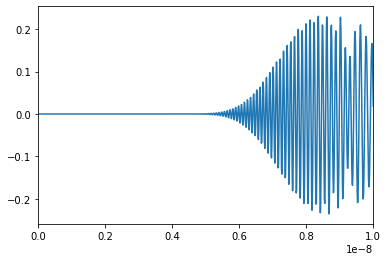

In [ ]:
for i in range(700):
  vgrid[1: N] = b1*psi[1:N] + b2*(psi[2:N+1] + psi[0:N-1])
  psi = banded(A_banded,vgrid,1,1)
plt.plot(xgrid, np.real(psi))
plt.xlim(0,L)

After 900 timesteps, the whole wavepacket would have bounced of the boundary and will start travelling towards the opposite direction. 

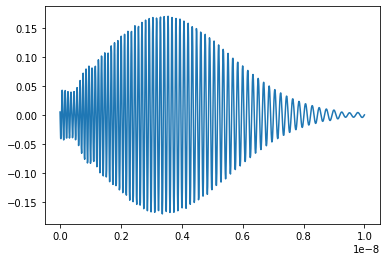

In [ ]:
for i in range(900):
  vgrid[1: N] = b1*psi[1:N] + b2*(psi[2:N+1] + psi[0:N-1])
  psi = banded(A_banded,vgrid,1,1)
plt.plot(xgrid, np.real(psi))

2. In the animation below, we can observe how the wave packet evolves over time (see final section for the Physics description, after Problem 2).

In [ ]:
from matplotlib import animation

def psi0(x):
  return exp(-(x - x0) ** 2 / (2 * sigma ** 2)) * exp(1j * kappa * x)

# initialize arrays
xgrid = np.linspace(0, L, N+1)
vgrid = np.zeros(N+1, complex)

psi = np.array(list(map(psi0, xgrid)), complex) #Obtains the initial value of the wavefunction in the region of interest

# define A_banded, the evolution operator
A_banded = np.zeros([3, N+1], complex)
A_banded[0,:] = a2
A_banded[1,:] = a1
A_banded[2,:] = a2

#For the animation, we store the solution of our numerical evaluation for each timestep

t_sol = []

for i in range(0,500):
  for j in range(10):
    vgrid[1: N] = b1*psi[1:N] + b2*(psi[2:N+1] + psi[0:N-1]) #Formula for v from Crank Nicolson method
    psi =  banded(A_banded,vgrid,1,1)#We use the function we defined previously to solve the eigenvalue equation Ax = v
  t_sol.append(np.real(psi)) #Appends solution for each timestep

fig, ax = plt.subplots()
plt.rc('animation', html='jshtml') #Allows playing the animation inline in Jupyter notebooks

x = xgrid
line, = ax.plot(xgrid, t_sol[0])

def animate(i):
    line.set_ydata(t_sol[int(i)]) 
    return line,

ani = animation.FuncAnimation(fig, animate, range(0,500), interval=20, blit=True, save_count=50)
ani


Output hidden; open in https://colab.research.google.com to view.

### PROBLEM 2 (50 pts.; 50/50 for code & discussion)

**The Schrodinger equation and the spectral method**

_Refer to Exercise 9.9 in the Newman text._ In this problem, you will use the spectral method to solve the time-dependent Schodinger equation for the same system as in Problem 1, a single particle in one dimension in a box of length $L$ with impenetrable walls. 

To perform the fast transforms needed for this problem, you can use the scipy $\tt fftpack$ package's discrete sine transform $\tt dst$ ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dst.html)) and inverse discrete sine transform $\tt idst$ ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.idst.html)). Alternatively, you can use the corresponding functions in the $\tt dcst$ package in Appendix E of the Newman text. 

1. Calculate the values of the coefficients $b_k$ which for convenience can be broken down into their real and imaginary parts as $b_k = \alpha_k + i \eta_k$· Divide the box into $N = 1000$ slices and create two arrays containing the real and imaginary parts of $\psi(x_n,0)$ at each grid point. Perform discrete sine transforms on each array separately and hence calculate the values of the $\alpha_k$ and $\eta_k$ for all $k=1$...$N-1$. *(15 pts.)*

2. Putting $b_k = \alpha_k +i \eta_k$ in the solution above and taking the real part we get $ {\rm Re}\ \psi(x_n, t) $ equals
$$\frac{1}{N} \sum_{k=1}^{N-1} \left[\alpha_k \cos\left(\frac{\pi^2\hbar k^2}{2ML^2}t\right) - \eta_k \sin\left(\frac{\pi^2\hbar k^2}{2ML^2}t\right)\right]\sin\left(\frac{\pi kn}{N}\right)$$
for the real part of the wavefunction. This is an inverse sine transform with coefficients equal to the quantities in the square brackets. 

   Calculate the real part of the wavefunction $\psi(x,t)$ at an arbitrary time $t$ using this formula and the inverse discrete sine transform function. *(10 pts.)* 
   
3. Test your program by making a graph of the wavefunction at time $t = 10^{-16}$ s. *(10 pts.)*

4. Make an animation of the wavefunction over time, similar to that described in part (4) of Problem 1 above. A suitable time interval for each frame of the animation is about $10^{-18}$ s. Run your animation for a while and describe what you see. Write a few sentences explaining in physics terms what is going on in the system. *(15 pts.)*


1. We import the needed packages and functions, including the real forward and inverse Fast Fourier transforms from numpy's ```fft``` package. We also define the discrete sine transform ```dst``` and inverse discrete sine transform ```idst``` functions from Newman's online resources. 

As in Problem 1, we define constants and parameters and a function to define the initial wavefunction ```psi0```.

In [1]:
%matplotlib inline
import numpy as np
from numpy.fft import rfft,irfft
import matplotlib.pyplot as plt

# define constants and parameters
L =  1e-8 # length of the box
sigma =  1e-10 # width of the wave packet
k = 5e10 #wave number
x0 =  L/2 # midpoint of the box
M = 9.109e-31 # mass of the electron in kg
hbar =  1.0546e-34
N = 1000

#Discrete sine transform
def dst(y):
    N = len(y)
    y2 = np.empty(2*N,float)
    y2[0] = y2[N] = 0.0
    y2[1:N] = y[1:]
    y2[:N:-1] = -y[1:]
    a = -np.imag(rfft(y2))[:N]
    a[0] = 0.0

    return a

#Inverse discrete sine transform
def idst(a):
    N = len(a)
    c = np.empty(N+1,complex)
    c[0] = c[N] = 0.0
    c[1:N] = -1j*a[1:]
    y = irfft(c)[:N]
    y[0] = 0.0

    return y

#Initial state of the wave packet (Gaussian)
def psi0(x):
  return np.exp(1j*k*x-((x-x0)**2/(2*sigma**2)))

The time-dependent  Schrödinger equation for a one-dimensional system is given by,

\begin{equation}  \left(-\frac{\hbar^{2}}{2M} \frac{d^{2}}{dx^{2}} + V(x)\right) \psi(x,t) = i\hbar\frac{\partial}{\partial t} \psi(x,t) \end{equation}

The system is composed of a confined electron ($m_{e} = 9.11\times 10^{-31} \text{kg}$) inside a one dimensional box of length $L=10^{-8} m$. We can express its solution in the following form,

\begin{equation} \psi_{k}(x,t) = \sin\left(\frac{\pi kx}{L}\right)e^{iEt/\hbar} \end{equation}

where the energy $E$ is given by

\begin{equation} 
E_{k} = \frac{\pi^{2}\hbar^{2}k^{2}}{2m_{e}L^{2}} 
\end{equation}

The general solution would then be a superposition of states that can be represented by the summation, 

\begin{equation} 
\psi(x_{n},t)=\frac{1}{N} \sum_{k=1}^{N-1} b_{k} \sin \left(\frac{\pi kn}{N}\right) \exp\left(i\frac{\pi^{2}\hbar k^{2}}{2m_{e}L^{2}}t\right) 
\end{equation}

where $x_{n} = nL/N$, and $b_{k}$ are coefficients that we need to determine.

At time $t=0$ the wave function starts with an initial state that takes the form of a Gaussian wavepacket $\psi_0$, 

\begin{equation} 
\psi(x,0)=\psi_0 = \exp\left(-\frac{(x-x_{0})^{2}}{2\sigma^{2}}\right)e^{i\kappa x} 
\end{equation}

where $x_{0} = L/2$ (midpoint) ,$\sigma=1\times 10^{-10} \text{m}$, and $\kappa=5\times 10^{10} \text{m}^{-1}$. 

Since $b_{k}$ is a complex number, we can split it to its real and imaginary parts:

\begin{equation} 
 b_{k} = \alpha_{k} + i\eta_{k} 
\end{equation}

which when subsituted back to our solution would give us, 

\begin{align} 
\psi(x_{n},t)&=\frac{1}{N} \sum_{k=1}^{N-1} b_{k} \sin \left(\frac{\pi kn}{N}\right) \exp\left(i\frac{\pi^{2}\hbar k^{2}}{2m_{e}L^{2}}t\right) \\
&= \frac{1}{N} \sum_{k=1}^{N-1} (\alpha_{k} + i\eta_{k} ) \sin \left(\frac{\pi kn}{N}\right) \exp\left(i\frac{\pi^{2}\hbar k^{2}}{2m_{e}L^{2}}t\right) 
\end{align}

We can use Euler's formula to express the exponential function in terms of sinusoidal functions [$\exp(ix) = \cos(x)+i\sin(x)$],
\begin{align} 
\psi(x_{n},t)&= \frac{1}{N} \sum_{k=1}^{N-1} (\alpha_{k} + i\eta_{k} ) \sin \left(\frac{\pi kn}{N}\right)\left[\cos\left(\frac{\pi^{2}\hbar k^{2}}{2m_{e}L^{2}}t\right) + i\sin\left(\frac{\pi^{2}\hbar k^{2}}{2m_{e}L^{2}}t\right) \right]
\end{align}
which we could decompose into its real and imaginary parts,
\begin{equation}
\text{Re}[\psi(x_n, t)] = \frac{1}{N} \sum_{k=1}^{N-1} \sin \left(\frac{\pi kn}{N}\right)\left[\alpha_k \cos\left(\frac{\pi^{2}\hbar k^{2}}{2m_{e}L^{2}}t\right) -\eta_k\sin\left(\frac{\pi^{2}\hbar k^{2}}{2m_{e}L^{2}}t\right) \right]
\end{equation}
and
\begin{equation}
\text{Im}[\psi(x_n, t)] = \frac{1}{N} \sum_{k=1}^{N-1} \sin \left(\frac{\pi kn}{N}\right)\left[\eta_k \cos\left(\frac{\pi^{2}\hbar k^{2}}{2m_{e}L^{2}}t\right) +\alpha_k\sin\left(\frac{\pi^{2}\hbar k^{2}}{2m_{e}L^{2}}t\right) \right]
\end{equation}

This expansion of the wavefunction in terms of a sinusoidal basis is in fact the discrete sine transform. What's left for us to evaluate are the unknown Fourier coefficients $\alpha_k$ and $\eta_k$. We use the ```dst``` function defined above to perform the discrete sine transforms:

In [2]:
m = np.zeros(N,complex)

xgrid = range(N)

for K in xgrid:
    m[K] = (psi0(K*L/N))
    
r =  dst(np.real(m))#alpha
i =  dst(np.imag(m))#eta

2. We define a function ```Psi``` to return the calculated wavefunction for a given time ```T```.

In [10]:
def Psi(T):
    p=np.empty(N,complex)
    for z in xgrid:
      p[z] = (1/N)*(np.sin((np.pi*z)/N))*(r[z]*np.cos(np.pi**2*hbar*z**2*T/2/M/L**2)-i[z]*np.sin(np.pi**2*hbar*z**2*T/2/M/L**2))
    return idst(p)

We plot the wavefunction for $t=10^{-16}$ s.

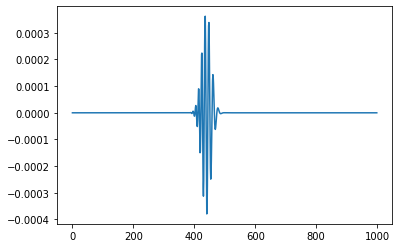

In [11]:
plt.plot(Psi(1e-16))
plt.show()

3. We create an animation similar to Problem 1.

In [ ]:
from matplotlib import animation

fig, ax = plt.subplots()
plt.rc('animation', html='jshtml')

x = np.arange(0, 100e-16,1e-17)
line, = ax.plot(x,Psi(1e-17))


def animate(i):
    line.set_ydata(Psi(i)) 
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, 100e-16,1e-17), interval=20, blit=True, save_count=50)
ani


# Physics Explanation for both Problems 1 and 2

In this exercise, we solved for the wavefunction solution of the Schrödinger equation describing an electron confined in a finite box of length $L$. The space beyond the walls of the box, not permitting any quantum tunneling effects, could be thought of as a region of infinite potential. In other words, the electron is classically forbidden to be located outside the box. Hence, the wavefunction could only reflect off the boundaries. 

Notice that as we evolve the system over time, the leading piece of the wavefunction bounces off the boundaries and interferes with the lagging piece. As we let the wavefunction reflect off the boundaries repeatedly, the wave is eventually dispersed inside the box. At a much later time, the wavefunction is expected to approach a stationary state (time-independent).